# Analytics dos dados na camada prata - Olist Dataset

## 1. Objetivo

Este notebook realiza a validação técnica e de negócio dos dados na Camada Prata (`public.orders`), após a execução do pipeline de ETL.

O objetivo é garantir que:
1.  Os dados foram carregados corretamente no PostgreSQL.
2.  Os tipos de dados (Schema) estão corretos (ex: monetários como Decimal).
3.  As regras de limpeza foram aplicadas (ex: `review_score` numérico).
4.  Os outliers foram tratados (distribuição estatística robusta).
5.  As novas colunas de engenharia de features estão consistentes.

In [1]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import os
from dotenv import load_dotenv
import warnings

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7) 
warnings.filterwarnings('ignore')

In [ ]:
spark = SparkSession.builder \
    .appName("AnaliseQualidadePrata") \
    .config("spark.jars.packages", "org.postgresql:postgresql:42.5.0") \
    .config("spark.sql.debug.maxToStringFields", 1000) \
    .config("spark.ui.showConsoleProgress", "false") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
print("SparkSession iniciada.")

## 2. Carregamento dos Dados (PostgreSQL)

Conexão via JDBC para leitura da tabela `public.orders`.

In [3]:
load_dotenv(dotenv_path='../../.env') 

env_vars = {
    "db_user": os.getenv("DB_USER"),
    "db_password": os.getenv("DB_PASSWORD"),
    "db_host": os.getenv("DB_HOST"),
    "db_port": os.getenv("DB_PORT"),
    "db_name": os.getenv("DB_NAME")
}

jdbc_url = f"jdbc:postgresql://{env_vars['db_host']}:{env_vars['db_port']}/{env_vars['db_name']}"
jdbc_properties = {
    "user": env_vars["db_user"],
    "password": env_vars["db_password"],
    "driver": "org.postgresql.Driver"
}

table_name = "public.orders"

print(f"Lendo tabela '{table_name}'...")

df_silver = spark.read.jdbc(
    url=jdbc_url,
    table=table_name,
    properties=jdbc_properties
)

df_silver.cache()

print(f"Total de linhas carregadas: {df_silver.count():,}")

Lendo tabela 'public.orders'...
Total de linhas carregadas: 88,981


## 3. Análise Estrutural e de Qualidade

Verificação do Schema, Nulos e Estatísticas Descritivas para validar a limpeza.

In [4]:
def analyze_spark_df(df, df_name):
    print(f"\n{'='*30}")
    print(f" ANÁLISE DO DATAFRAME: {df_name.upper()} ")
    print(f"{'='*30}")

    total_linhas = df.count()
    total_colunas = len(df.columns)
    print(f"\nQuantidade de linhas e colunas: ({total_linhas:,}, {total_colunas})")

    print("\nInformações detalhadas (Schema):")
    df.printSchema()

    print("\nContagem de nulos:")
    null_check_conditions = []
    for col_name, col_type in df.dtypes:
        base_condition = F.col(col_name).isNull()
        if col_type == 'string':
            condition = F.when(base_condition | (F.trim(F.col(col_name)) == ""), 1).otherwise(0)
        elif col_type in ['double', 'float', 'decimal']:
            condition = F.when(base_condition | F.isnan(F.col(col_name)), 1).otherwise(0)
        else:
            condition = F.when(base_condition, 1).otherwise(0)
        null_check_conditions.append(F.sum(condition).alias(col_name))
    
    null_df = df.select(null_check_conditions).first()
    null_counts = {c: null_df[c] for c in df.columns if null_df[c] > 0}
    
    if null_counts:
        print(pd.DataFrame(null_counts.items(), columns=['Coluna', 'Nulos']).to_string(index=False))
    else:
        print("SUCESSO: Nenhum valor nulo encontrado (exceto onde permitido).")

    print("\nEstatísticas descritivas (colunas numéricas):")
    numeric_cols = [c for c, t in df.dtypes if t in ['int', 'bigint', 'double', 'float', 'decimal', 'long']]
    
    if numeric_cols:
        desc_pd = df.select(numeric_cols).describe().toPandas()
        desc_pd.set_index('summary', inplace=True)
        print(desc_pd.T.to_string()) 
    
    print("-" * 45)
    print("Análise concluída.")

In [5]:
analyze_spark_df(df_silver, 'Silver Orders')


 ANÁLISE DO DATAFRAME: SILVER ORDERS 

Quantidade de linhas e colunas: (88,981, 24)

Informações detalhadas (Schema):
root
 |-- order_item_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)
 |-- price: decimal(10,2) (nullable = true)
 |-- freight_value: decimal(10,2) (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- seller_city: string (nullable = true)
 |-- seller_state: string (nu

## 4. Validação das Regras de Negócio

Verificação visual da imputação de categorias e do tratamento de outliers.

In [6]:
print("Verificação da coluna 'product_category_name':")

nulos = df_silver.filter(F.col("product_category_name").isNull()).count()
unknowns = df_silver.filter(F.col("product_category_name") == "unknown").count()

print(f"Total de Nulos (Deve ser 0): {nulos}")
print(f"Total de 'unknown' (Imputados): {unknowns}")

Verificação da coluna 'product_category_name':
Total de Nulos (Deve ser 0): 0
Total de 'unknown' (Imputados): 1417


### 4.1. Validação Visual de Outliers

Reconstrução dos boxplots para confirmar que os valores extremos de preço e frete foram removidos pelo método IQR.


--- Distribuição Pós-Limpeza: price ---


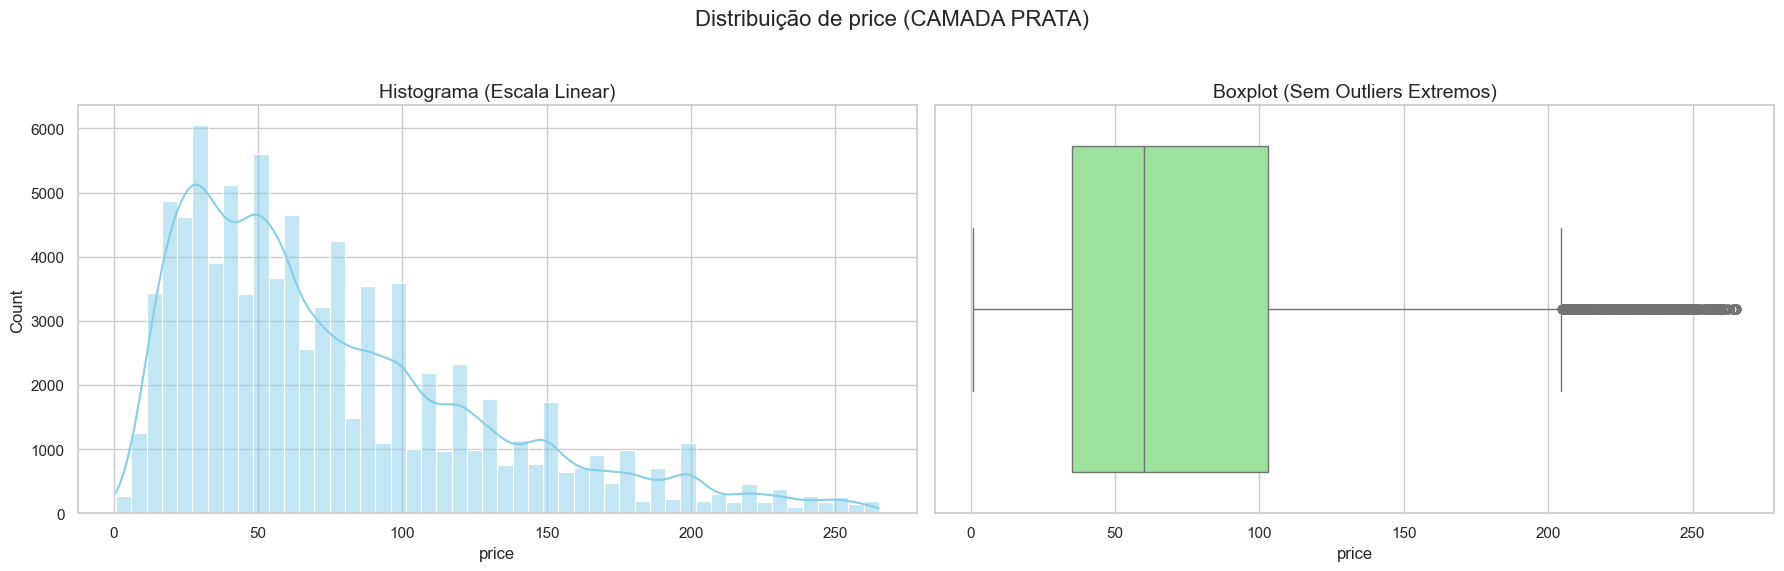


--- Distribuição Pós-Limpeza: freight_value ---


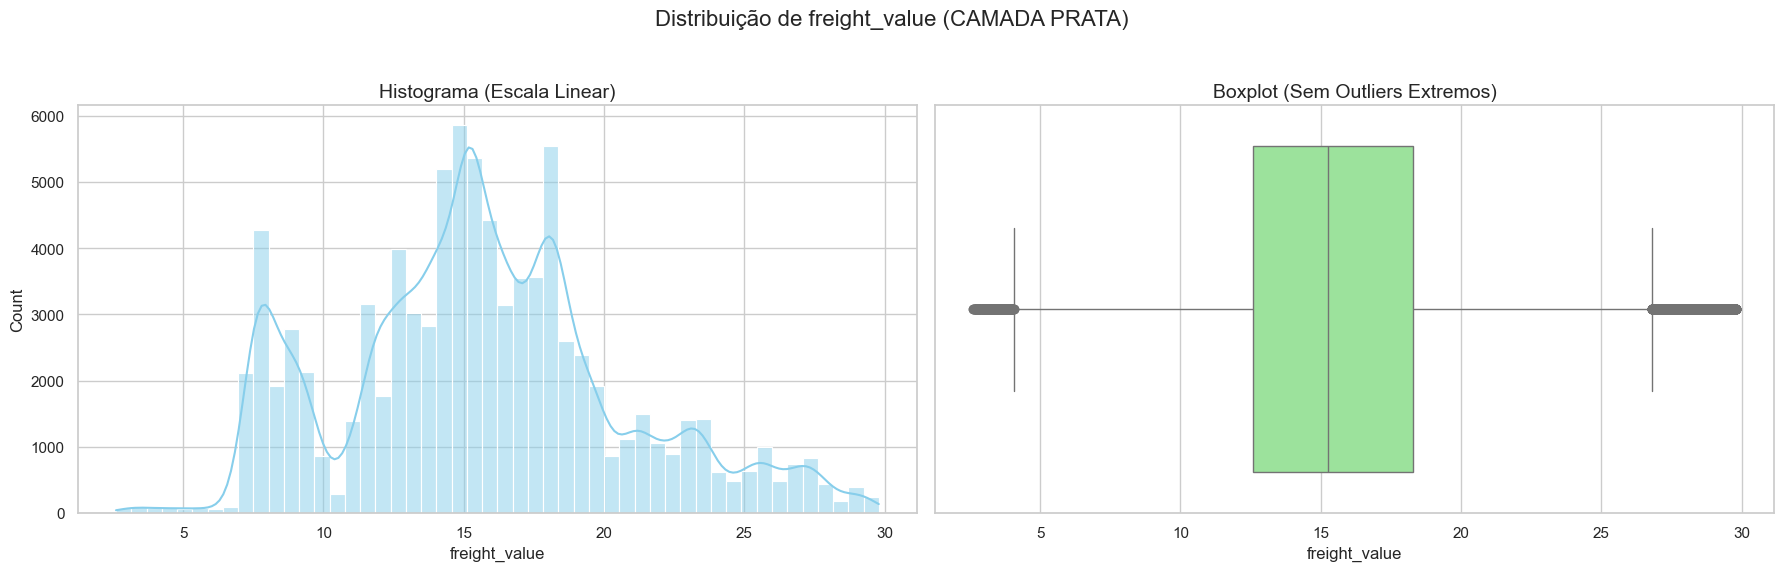

In [7]:
colunas_para_plotar = ['price', 'freight_value']

for coluna in colunas_para_plotar:
    print(f"\n--- Distribuição Pós-Limpeza: {coluna} ---")
    
    dados_pd = df_silver.select(coluna).toPandas()
        
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Distribuição de {coluna} (CAMADA PRATA)', fontsize=16)

    sns.histplot(dados_pd[coluna], bins=50, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('Histograma (Escala Linear)', fontsize=14)
    axes[0].set_xlabel(coluna, fontsize=12)

    sns.boxplot(x=dados_pd[coluna], ax=axes[1], color='lightgreen')
    axes[1].set_title('Boxplot (Sem Outliers Extremos)', fontsize=14)
    axes[1].set_xlabel(coluna, fontsize=12)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 5. Análise das Novas Features (Insights)

Validação das métricas criadas: `delivery_days` e `is_delivery_late`.

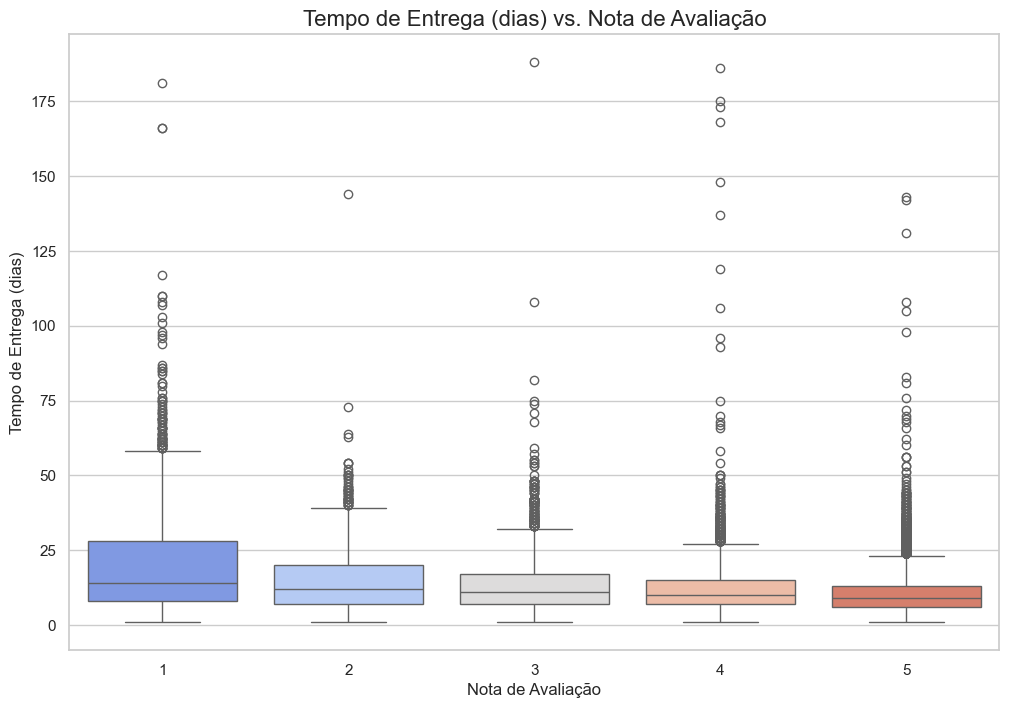

In [8]:
df_analise_pd = df_silver.select(
    "review_score", 
    "delivery_days"
).filter(
    F.col("review_score").isNotNull() & F.col("delivery_days").isNotNull()
).sample(withReplacement=False, fraction=0.5, seed=42).toPandas()

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_analise_pd,
    x='review_score',
    y='delivery_days',
    palette='coolwarm'
)
plt.title('Tempo de Entrega (dias) vs. Nota de Avaliação', fontsize=16)
plt.xlabel('Nota de Avaliação', fontsize=12)
plt.ylabel('Tempo de Entrega (dias)', fontsize=12)
plt.show()

Analisando o impacto de atrasos na Nota de Avaliação...


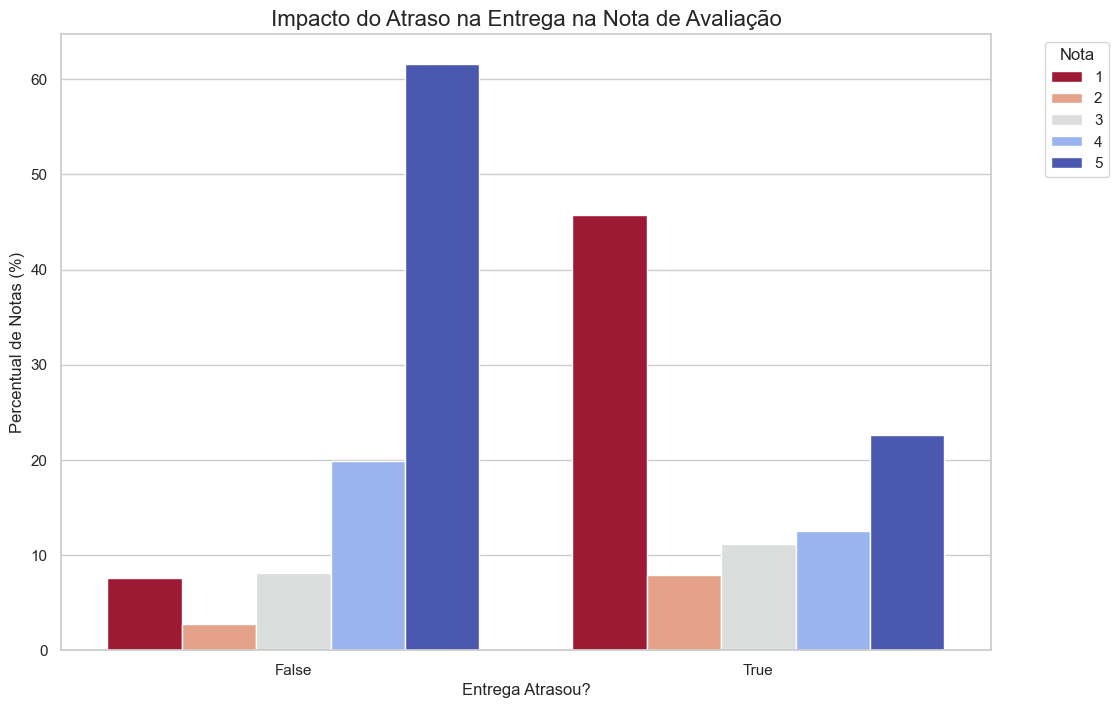

In [9]:
print("Analisando o impacto de atrasos na Nota de Avaliação...")

df_atraso_pd = df_silver.select(
    "review_score", 
    "is_delivery_late"
).filter(
    F.col("review_score").isNotNull() & F.col("is_delivery_late").isNotNull()
).groupBy("is_delivery_late", "review_score").count().toPandas()

df_atraso_pd['percentual'] = df_atraso_pd.groupby('is_delivery_late')['count'].transform(lambda x: 100 * x / x.sum())

plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_atraso_pd,
    x='is_delivery_late',
    y='percentual',
    hue='review_score',
    palette='coolwarm_r' 
)
plt.title('Impacto do Atraso na Entrega na Nota de Avaliação', fontsize=16)
plt.xlabel('Entrega Atrasou?', fontsize=12)
plt.ylabel('Percentual de Notas (%)', fontsize=12)
plt.legend(title='Nota', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 6. Conclusão da Validação

A análise confirma que a tabela `public.orders` está em conformidade com os requisitos de qualidade:

1.  **Integridade:** Dados carregados com sucesso no PostgreSQL.
2.  **Schema:** Tipos de dados (`Decimal`, `Integer`) aplicados corretamente.
3.  **Qualidade:** Colunas como `review_score` estão limpas e nulos de categoria foram tratados.
4.  **Estatística:** Outliers de preço e frete foram removidos, resultando em distribuições consistentes.
5.  **Negócio:** As novas features confirmam a forte correlação entre eficiência logística e satisfação do cliente.

Os dados estão prontos para a modelagem da Camada Ouro.

In [10]:
spark.stop()
print("Sessão finalizada.")

Sessão finalizada.
